In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

from metrics import calculate_metrics

Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
def plot_batch_effect_ndreamer(dataset_name, cell_type_key, batch_key, condition_key):
    if isinstance(batch_key, str):
        batch_key = [batch_key]

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("batch.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + integrated.obs[condition_key][i]
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")

    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)

    print("Within each unique condition, plot batch effect")
    unique_conditions = np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Now evaluating", conditioni, "denoised expression")
        integratedi = integrated[integrated.obs[condition_key] == conditioni]
        for colori in [cell_type_key] + batch_key:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("-" * 20)

In [3]:
dataset_names=["ECCITE_perturbation","ECCITE","ASD01","ASD101"]
cell_type_keys=["Phase","Phase","CellType","CellType"]
batch_keys=["replicate","replicate","Batch","Batch"]
condition_keys=["perturbation","perturbation","perturb01","perturb01"]

Evaluating ECCITE_perturbation
batch_all_denoise ['rep1' 'rep2' 'rep3']
batch_all_with_condition_denoise ['rep1__NT' 'rep1__Perturbed' 'rep2__NT' 'rep2__Perturbed' 'rep3__NT'
 'rep3__Perturbed']


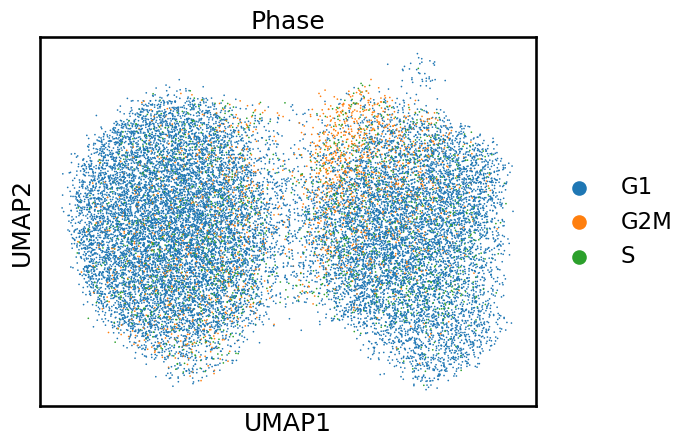

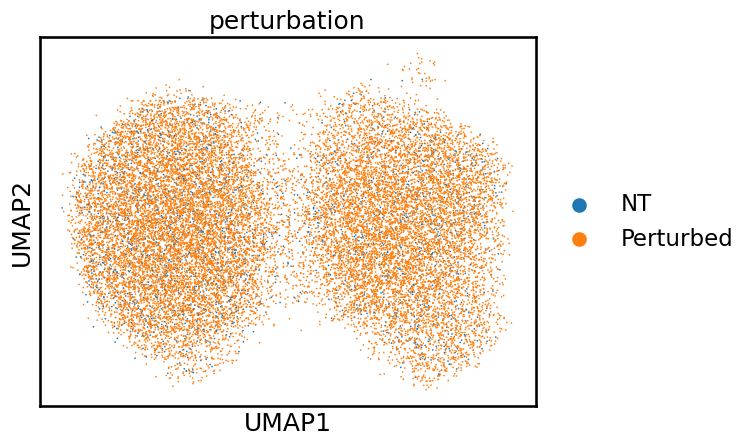

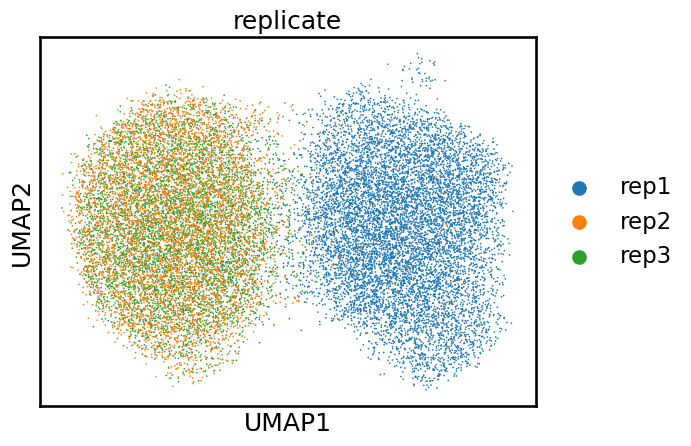

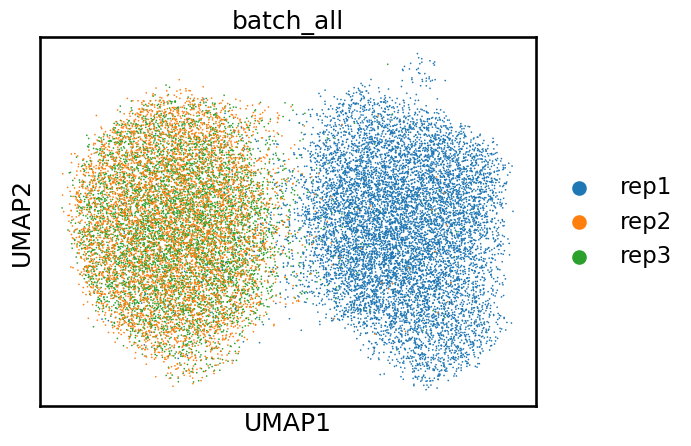

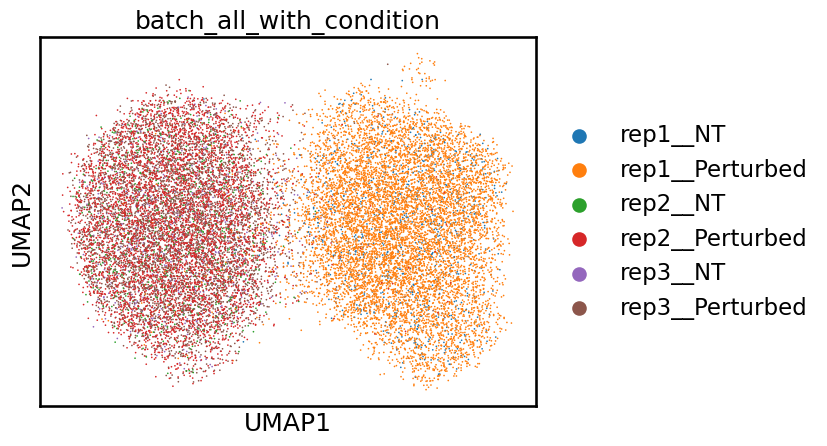

Within each unique condition, plot batch effect
Now evaluating NT denoised expression


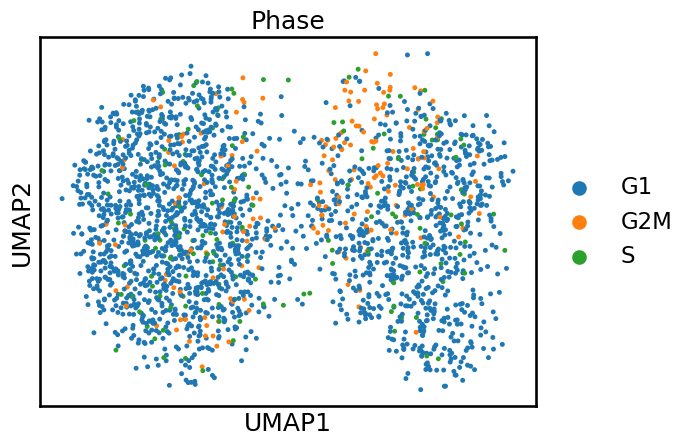

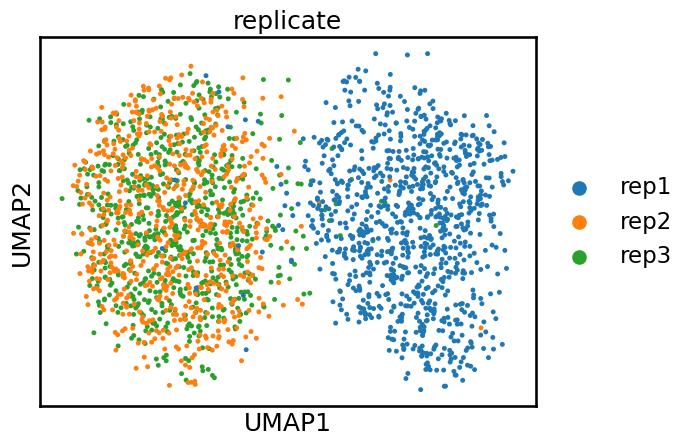

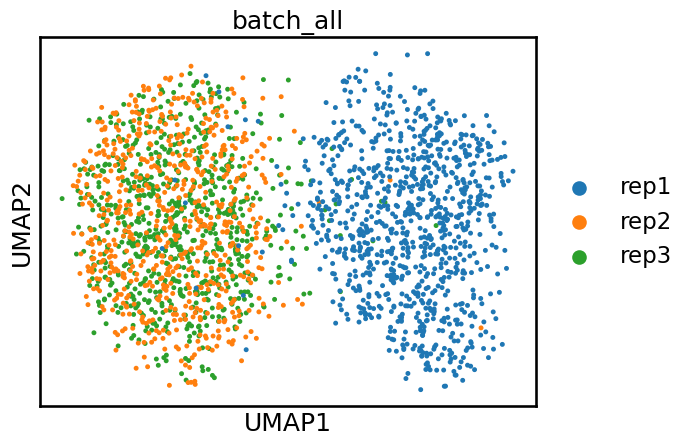

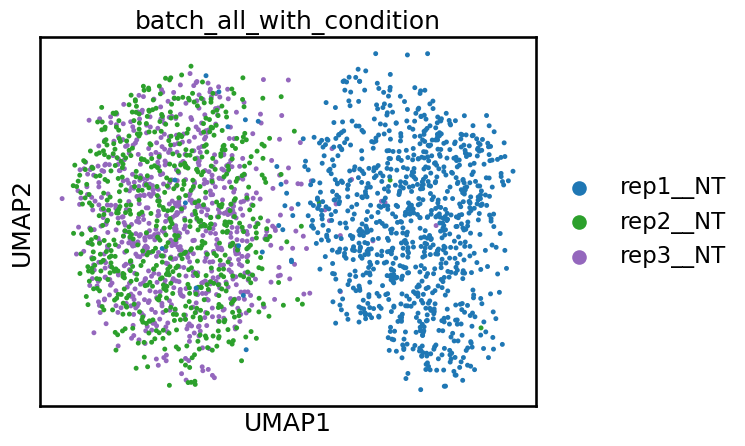

--------------------
Now evaluating Perturbed denoised expression


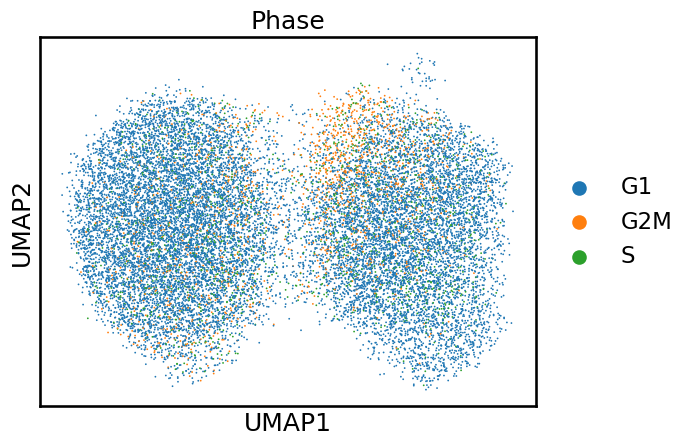

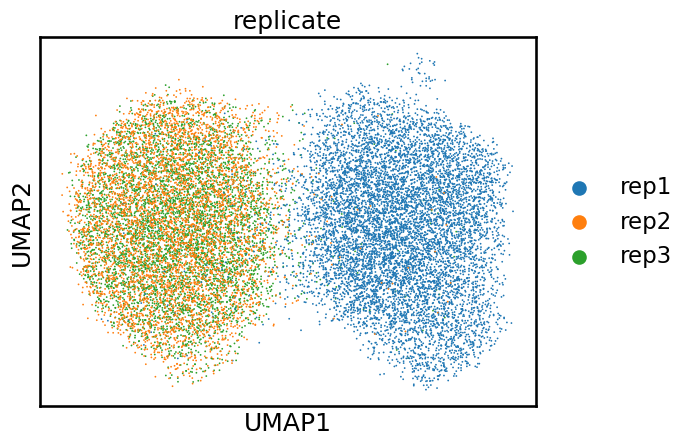

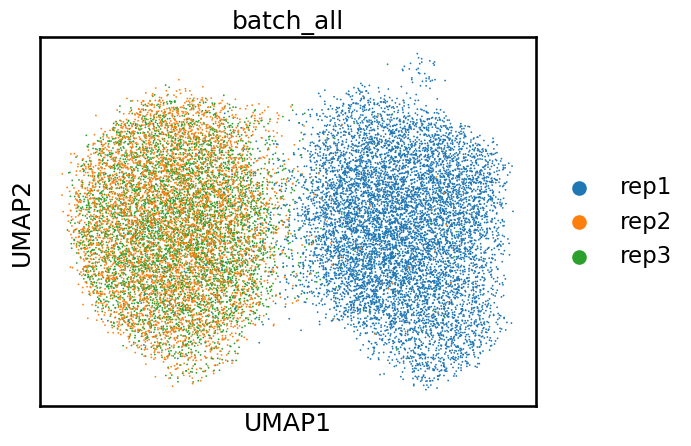

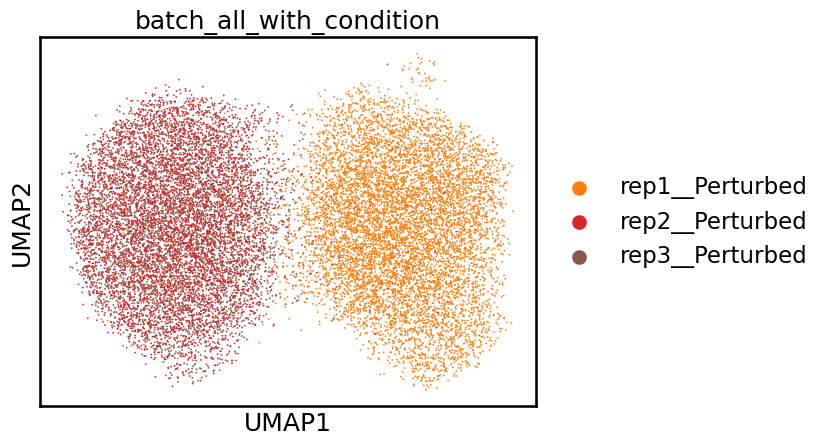

--------------------
------------------------------
Evaluating ECCITE
batch_all_denoise ['rep1' 'rep2' 'rep3']
batch_all_with_condition_denoise ['rep1__NT' 'rep1__Perturbed' 'rep2__NT' 'rep2__Perturbed' 'rep3__NT'
 'rep3__Perturbed']


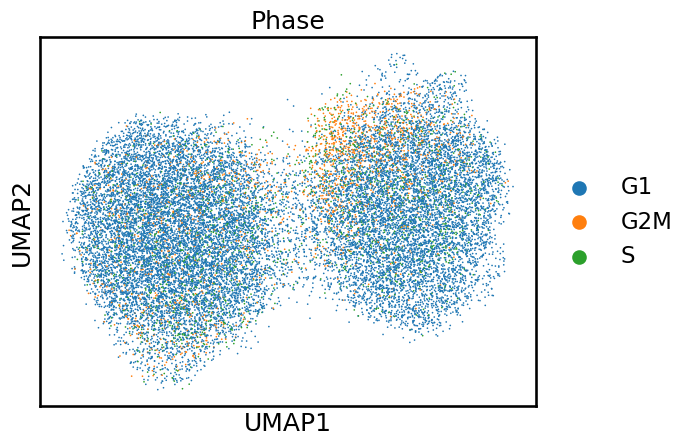

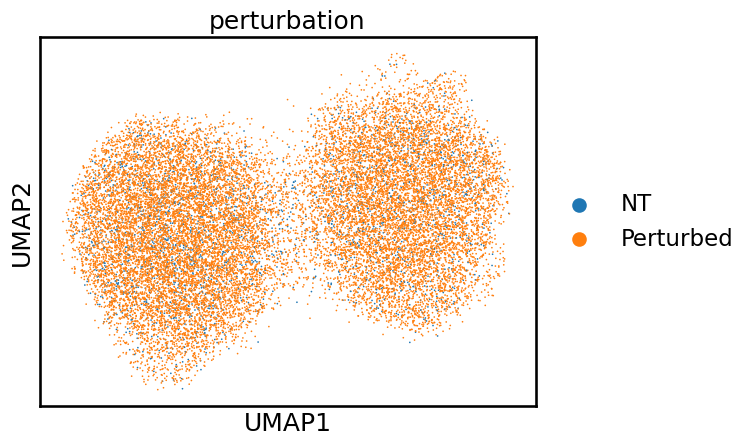

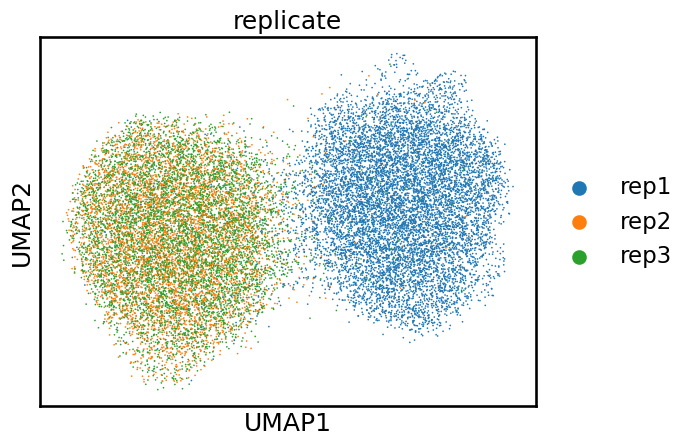

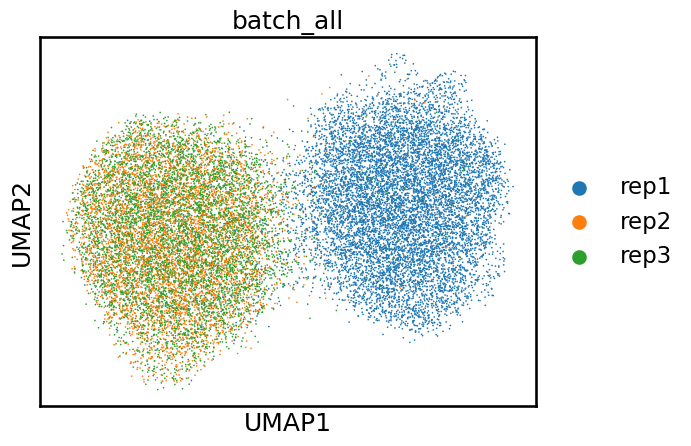

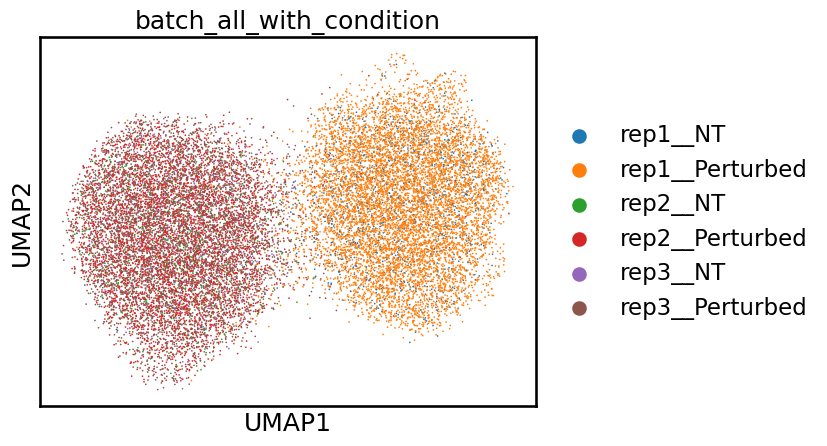

Within each unique condition, plot batch effect
Now evaluating NT denoised expression


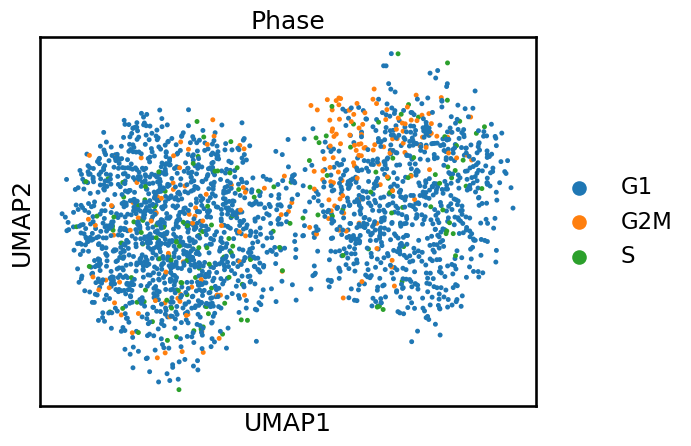

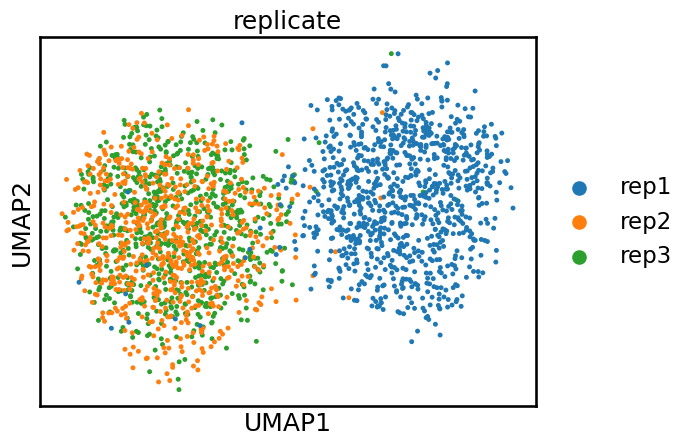

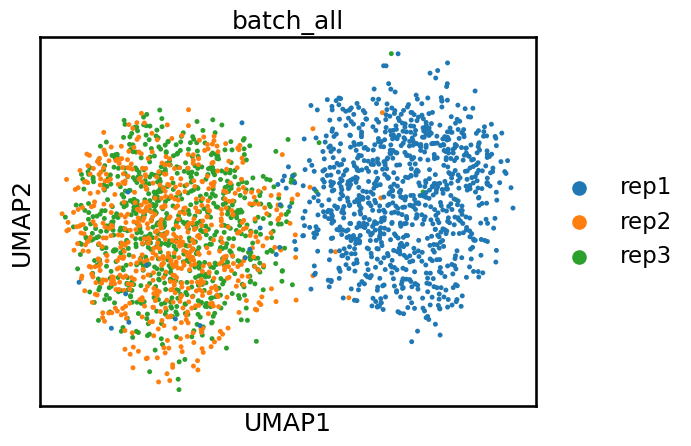

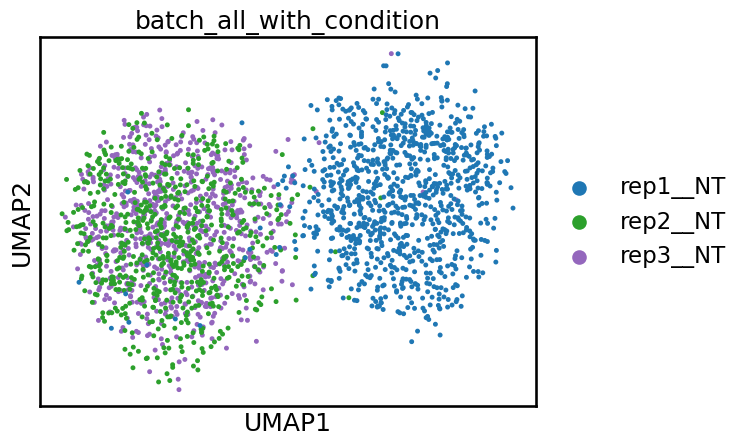

--------------------
Now evaluating Perturbed denoised expression


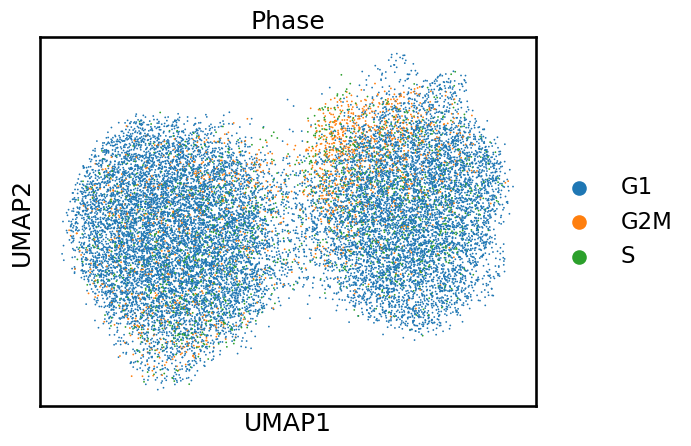

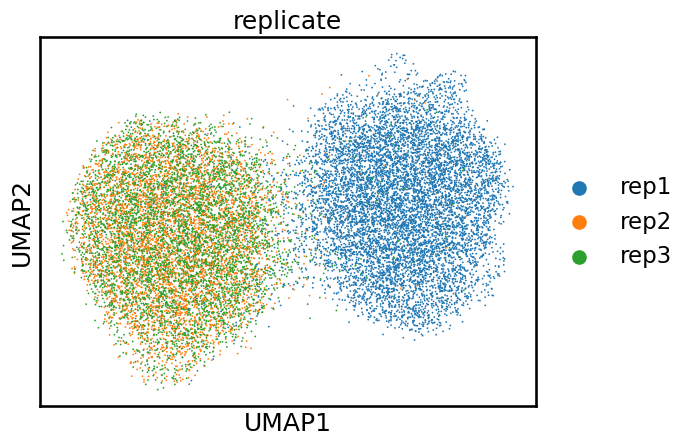

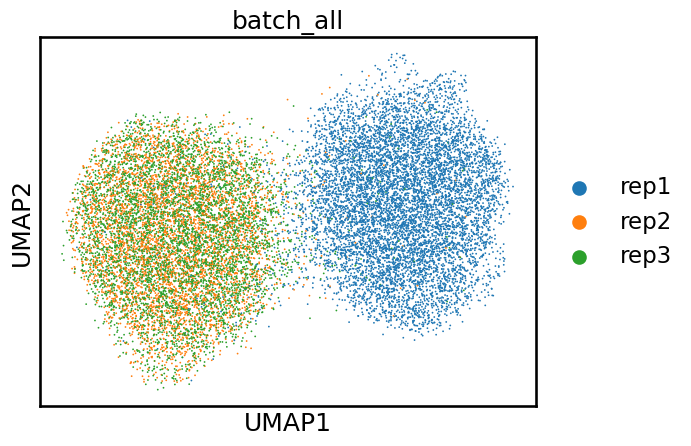

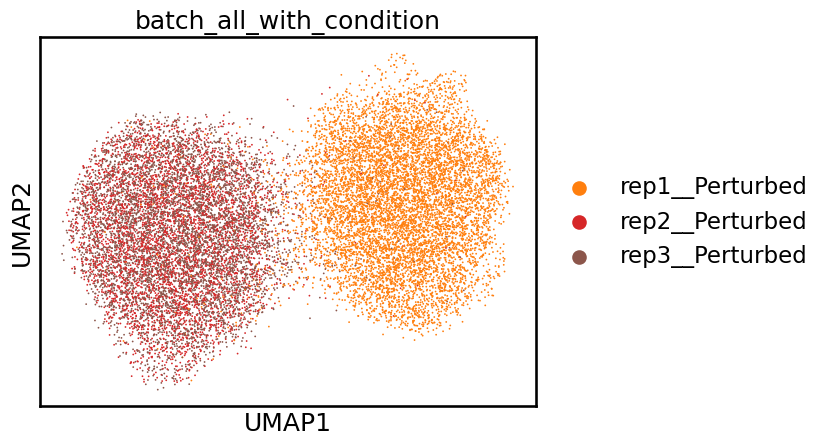

--------------------
------------------------------
Evaluating ECCITE_perturbation_nobatch


ValueError: No objects to concatenate

In [4]:
for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    print("Evaluating",dataset_name)
    plot_batch_effect_ndreamer(dataset_name=dataset_name,cell_type_key=cell_type_keys[i],batch_key=batch_keys[i],condition_key=condition_keys[i])
    print("-"*30)